In [12]:
from openai import OpenAI
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

In [13]:
ems = """
        admiration
        amusement
        anger
        annoyance
        approval
        caring
        confusion
        curiosity
        desire
        disappointment
        disapproval
        disgust
        embarrassment
        excitement
        fear
        gratitude
        grief
        joy
        love
        nervousness
        optimism
        pride
        realization
        relief
        remorse
        sadness
        surprise
        neutral
    """

In [14]:
def emotions_to_categorical(df):
    res = []

    for i in df['emotions']:
        tmp = [0 for _ in range(28)]
        for j in i:
            tmp[j] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=ems.split())
    
    return tmp_df

In [15]:
def emotions_to_ekman(df):
    # anger disgust fear joy sadness surprise neutral
    ekman = [3, 3, 0, 0, 3, 3, 5, 5, 3, 4, 0, 1, 4, 3, 2, 3, 4, 3, 3, 2, 3, 3, 5, 3, 4, 4, 5, 6]
    res = []

    for i in df:
        tmp = [0, 0, 0, 0, 0, 0, 0]
        for j in range(len(i)):
            if i[j] == 1:
                tmp[ekman[j]] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])
    
    return tmp_df

In [16]:
def data_init(path = "../data/dev.tsv"):
    df = pd.read_csv(path, sep="\t", encoding = "utf-8", header=None)
    df.columns = ['text', 'emotions', 'id']
    df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), df['emotions']))
    df = pd.concat([df, emotions_to_categorical(df)], axis=1)
    df = df.drop(columns=['emotions', 'id'])
    df['text'] = list(map(lambda s : s.replace('\\', '\\\\').replace('"', '\\"'), list(df['text']))) 
    return df.iloc[:2500, :]

In [17]:
def evaluation(original_df, emotion_res):
    emotions_list = ems.split()
    df = original_df
    predicted_df = pd.DataFrame(data = [[0 for _ in range(28)] for _ in range(len(df))], columns=emotions_list)
    for i in range(len(emotion_res)):
        for j in emotion_res[i]:
            if j in emotions_list:
                predicted_df.loc[i, j] = 1
    predicted = predicted_df.to_numpy()
    original = df.iloc[:,1:].to_numpy()
    
    accuracy = accuracy_score(original, predicted)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        original, predicted, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        original, predicted, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        original, predicted, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotions_list)):
        print(f"{emotions_list[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")

    return accuracy, f1_micro, f1_macro

In [18]:
def evaluation_ekman(original_df, emotion_res):
    emotions_list = 'anger disgust fear joy sadness surprise neutral'.split()
    predicted_df = pd.DataFrame(data = [[0 for _ in range(28)] for _ in range(len(original_df))], columns=ems.split())
    for i in range(len(emotion_res)):
        for j in emotion_res[i]:
            if j in ems.split():
                predicted_df.loc[i, j] = 1
    predicted = emotions_to_ekman(predicted_df.to_numpy()).to_numpy()
    original = emotions_to_ekman(original_df.iloc[:,1:].to_numpy()).to_numpy()

    accuracy = accuracy_score(original, predicted)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        original, predicted, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        original, predicted, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        original, predicted, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotions_list)):
        print(f"{emotions_list[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")

    return accuracy, f1_micro, f1_macro

In [19]:
persona_file = open('./prompt/persona.txt', 'r')
persona = persona_file.read()
persona_file.close()

In [20]:
guidelines_file = open('./prompt/guidelines.txt', 'r')
guidelines = guidelines_file.read()
guidelines_file.close()

In [21]:
output_structure_file = open('./prompt/output_structure.txt', 'r')
output_structure = output_structure_file.read()
output_structure_file.close()

In [22]:
few_shot_file = open('./prompt/few_shot.txt', 'r')
# few_shot = few_shot_file.read().replace('  ', "").replace('   ', "").replace('    ', "").replace('     ', "").replace('      ', "").replace('\n'," ").replace('\t', " ").replace('"', "'").replace('{ ', '{').replace('[ ', '[').replace(' }', '}').replace(' ]', ']')
few_shot = few_shot_file.read()
few_shot_file.close()

In [23]:
chain_of_thought_file = open('./prompt/chain_of_thought.txt', 'r')
# chain_of_thought = chain_of_thought_file.read().replace('\n', ' ').replace('"', "'")
chain_of_thought = chain_of_thought_file.read()
chain_of_thought_file.close()

In [24]:
# system = f"We are trying to classify 28 emotions of goemotion, please read the prompt below carefully and proceed with the classification without errors. {persona}, {guidelines}, {chain_of_thought}, {output_structure}, {few_shot_example}"
system = f"{persona}{guidelines}{output_structure}"

In [25]:
print(system)

(PERSONA ROLE) 
You are an expert system specializing in emotion classification, designed to analyze text with a highly analytical and empathetic approach. You excel at detecting and interpreting a wide range of emotions, considering nuanced language and complex emotional cues. 
Read the Reddit post, identify the emotions expressed, and choose the emotion label that best matches the overall sentiment.
The following 28 emotion label: [admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral].
(PERSONA ROLE END)
(GUIDELINES) 
1. Think step by step carefully, First, identify key phrases and their emotional cues in the text. Second, consider which of the 28 labels best match these cues.
2. Default to a single emotion. Your primary goal is to find the single most dominant emo

In [26]:
data = data_init()

In [ ]:
origin = [0, 0.25, 0.5, 0.75, 1]
top_p = [0, 0.125, 0.25, 0.5, 0.75, 1]
temperature = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2]

In [ ]:
values = []
for i in temperature:
    for j in top_p:
        if i in origin and j in origin:
            continue
        values.append((i, j))

In [30]:
print(values)

[]


In [ ]:
i = 0
for j in values:
    with open(f"./inputs/few_shot_grid/grid_{i}.jsonl", "w") as f:
        k = 0
        for record in data["text"]:
            baseQuery = {
            "custom_id": f"query{k}",
            "method": "POST",
            "url": "/v1/responses",
            "body": {
                    "model": "gpt-4o-mini",
                    "temperature": j[0],
                    "top_p": j[1],
                    "input": [{
                        "role": "developer",
                        "content": f"{system}"
                    }, 
                    {
                        "role": "user",
                        "content": f"{record}"
                    }], 
                    "max_output_tokens": 1000,
                    "text": {
                        "format": {
                            "type": "json_schema",
                            "name": "result",
                            "strict": True,
                            "schema": {
                                "type": "object",
                                "properties": {
                                    "analysis": {
                                        "type": "array",
                                        "items": {
                                            "type": "object",
                                            "properties": {
                                                "emotion": {
                                                    "type": "string",
                                                    "enum": [ "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral" ]
                                                },
                                                "reason": {
                                                    "type": "string"
                                                }
                                            },
                                            "required": ["emotion", "reason"],
                                            "additionalProperties": False
                                        }
                                    }
                                },
                                "required": ["analysis"],
                                "additionalProperties": False
                            }
                        }
                    }
                }
            }
            k += 1
            f.write(json.dumps(baseQuery) + "\n")
    i += 1

In [10]:
key_file = open('./key/openai_key.txt', 'r')
api_key = key_file.readline()
key_file.close()

In [11]:
client = OpenAI(api_key=api_key)

In [263]:
batch_list = [""] * 25

In [267]:
print(batch_list)

['batch_68f59a9be74c8190aa3bfd167ccd57c4', 'batch_68f59a9e7b9c81909e9db8203ce911a7', 'batch_68f59aa078f08190912209509e87993e', 'batch_68f59aa2d54c8190932de5696ab8de39', 'batch_68f59ade977c819087be4149bcaa4d77', 'batch_68f59ae0f4408190a2ecd9bf58faa43a', 'batch_68f59ae315748190be14ef08dbf50b50', 'batch_68f59ae5793881908df292dfbc95ddef', 'batch_68f59ae82fc08190b50c5075b3e4d583', 'batch_68f59ae9ec788190b08ee662f1007806', 'batch_68f59aed169481909bce6b0fd08e366f', 'batch_68f59aee912c8190a9e997f8c1bb7427', 'batch_68f59af069c48190a86a077d0d525029', 'batch_68f59af390cc819098a3380d3e910955', 'batch_68f59af5996881909fa06ae06dc3152d', 'batch_68f59af8059c819091a353272174adb5', 'batch_68f59afa0ce881909383f3e4843f2202', 'batch_68f59afbd7788190a8bc1fd1319612c9', 'batch_68f59afe5334819082d0caf50a3d4dbc', 'batch_68f59b00847c81908ab0041c5e0ca1b5', 'batch_68f59b0252c8819092bb8e12e9df20a1', 'batch_68f59b0488d0819094ea337117c55114', 'batch_68f59b07f1888190bc3512f620d08932', 'batch_68f59b09c0748190adfbf51c18

In [266]:
for i in range(4, 25):
    batch_input_file = client.files.create(
        file=open(f"./inputs/grid/grid_{i}.jsonl", "rb"),
        purpose='batch'
    )
    print(batch_input_file)
    
    batch_input_file_id = batch_input_file.id
    create_batch=client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/responses",
        completion_window="24h",
    )
    batch_list[i] = create_batch.id


FileObject(id='file-AMpGNUUtuNjB9ZJQztQgoj', bytes=8817821, created_at=1760926430, filename='grid_4.jsonl', object='file', purpose='batch', status='processed', expires_at=1763518430, status_details=None)
FileObject(id='file-13yJd1wq2Z36xDpWRiEf9W', bytes=8825321, created_at=1760926432, filename='grid_5.jsonl', object='file', purpose='batch', status='processed', expires_at=1763518432, status_details=None)
FileObject(id='file-TjSj3Tf8ajXvg94wELZ1uh', bytes=8832821, created_at=1760926434, filename='grid_6.jsonl', object='file', purpose='batch', status='processed', expires_at=1763518434, status_details=None)
FileObject(id='file-YHrNeBjEh2kh7dUngRg7C7', bytes=8830321, created_at=1760926436, filename='grid_7.jsonl', object='file', purpose='batch', status='processed', expires_at=1763518436, status_details=None)
FileObject(id='file-AX4TWq3e88BG3XvDRzDnwz', bytes=8832821, created_at=1760926439, filename='grid_8.jsonl', object='file', purpose='batch', status='processed', expires_at=1763518439, s

In [268]:
batch_res = [0] * 25

In [286]:
cnt = 0
for i in range(len(batch_list)):
    print(i, end=" ")
    if batch_res[i] != 0:
        print("done")
        cnt += 1
        continue
    batch = client.batches.retrieve(batch_list[i])
    result = None
    if batch.status == 'completed':
        out = batch.output_file_id
        if out != None:
            cnt += 1
            print('done!')
            result = client.files.content(out)
            batch_res[i] = result
        else:
            print('error')
            result = client.files.content(batch.error_file_id).text
            batch_res[i] = result
    elif batch.status == 'failed':
        print('failed')
        print(batch.errors)
    else:
        print('it does not finish yet')
        print(batch.status)
        print(batch.request_counts)
print(cnt, "/ 25")

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done!
23 done
24 done
25 / 25


In [376]:
t = []
for i in temperature:
    for j in top_p:
        t.append((float(i), float(j)))

In [377]:
print(t)

[(0.0, 0.0), (0.0, 0.25), (0.0, 0.5), (0.0, 0.75), (0.0, 1.0), (0.25, 0.0), (0.25, 0.25), (0.25, 0.5), (0.25, 0.75), (0.25, 1.0), (0.5, 0.0), (0.5, 0.25), (0.5, 0.5), (0.5, 0.75), (0.5, 1.0), (0.75, 0.0), (0.75, 0.25), (0.75, 0.5), (0.75, 0.75), (0.75, 1.0), (1.0, 0.0), (1.0, 0.25), (1.0, 0.5), (1.0, 0.75), (1.0, 1.0)]


In [378]:
evaluate = {}
for k in range(len(batch_res)):
    print("--------------------------", k, end='--------------------------\n')
    json_res = []
    for i in batch_res[k].text.split('\n')[:-1]:
        json_res.append(json.loads(i))
    emotion_res = []

    for i in json_res:
        tmp = []
        try:
            l = json.loads(i['response']['body']['output'][0]['content'][0]['text'])
            
            for j in l['analysis']:
                tmp.append(j['emotion'])
        except:
            print(i)
        
        emotion_res.append(tmp)
    e = evaluation(data, emotion_res)
    ek = evaluation_ekman(data, emotion_res)
    evaluate[t[k]] = list(e) + list(ek)
        

-------------------------- 0--------------------------
--- 모델 평가 결과 ---
전체 샘플에 대한 정확도 (Exact Match Accuracy): 0.2244

--- Micro 평균 지표 ---
Precision (Micro): 0.3125
Recall (Micro): 0.2701
F1-Score (Micro): 0.2897

--- Macro 평균 지표 ---
Precision (Macro): 0.3727
Recall (Macro): 0.3120
F1-Score (Macro): 0.2902

--- 라벨별 지표 ---
admiration - Precision: 0.6500, Recall: 0.1711, F1-Score: 0.2708
amusement - Precision: 0.3021, Recall: 0.6959, F1-Score: 0.4213
anger - Precision: 0.2421, Recall: 0.6778, F1-Score: 0.3567
annoyance - Precision: 0.1806, Recall: 0.0929, F1-Score: 0.1226
approval - Precision: 0.2410, Recall: 0.1156, F1-Score: 0.1562
caring - Precision: 0.2951, Recall: 0.2769, F1-Score: 0.2857
confusion - Precision: 0.1498, Recall: 0.5000, F1-Score: 0.2305
curiosity - Precision: 0.2182, Recall: 0.3130, F1-Score: 0.2571
desire - Precision: 0.3889, Recall: 0.2059, F1-Score: 0.2692
disappointment - Precision: 0.1527, Recall: 0.2532, F1-Score: 0.1905
disapproval - Precision: 0.2113, Recall: 0

In [379]:
print(evaluate)

{(0.0, 0.0): [0.2244, 0.289707750952986, 0.29024781718346315, 0.4548, 0.5075585789871504, 0.4436318083455104], (0.0, 0.25): [0.2236, 0.2893447086585587, 0.2855926256537827, 0.4548, 0.5076545076545077, 0.44597022569871464], (0.0, 0.5): [0.224, 0.2894975512425177, 0.28956292514781323, 0.4536, 0.5068932955618508, 0.44303576930811767], (0.0, 0.75): [0.2264, 0.29245283018867924, 0.29317099468918545, 0.4572, 0.5106785106785107, 0.44557519966778153], (0.0, 1.0): [0.2256, 0.2891916439600363, 0.286680279852414, 0.4528, 0.5051039697542533, 0.441886528129043], (0.25, 0.0): [0.224, 0.28929219600725953, 0.290984029551434, 0.4548, 0.5071860816944024, 0.443239947278968], (0.25, 0.25): [0.2236, 0.29115992013069525, 0.2915046054641585, 0.4572, 0.5097371903951597, 0.4442975072495047], (0.25, 0.5): [0.228, 0.29343489299963726, 0.2951949834415063, 0.456, 0.5090702947845805, 0.44417058745775756], (0.25, 0.75): [0.2288, 0.29493923453654997, 0.2914582198079928, 0.458, 0.5111446921042689, 0.4463184688762758],

In [380]:
res = pd.DataFrame(evaluate).transpose()

In [385]:
res

accuracy  f1 micro  f1 macro  ekman accuracy  ekman f1 micro  \
0.00 0.00    0.2244  0.289708  0.290248          0.4548        0.507559   
     0.25    0.2236  0.289345  0.285593          0.4548        0.507655   
     0.50    0.2240  0.289498  0.289563          0.4536        0.506893   
     0.75    0.2264  0.292453  0.293171          0.4572        0.510679   
     1.00    0.2256  0.289192  0.286680          0.4528        0.505104   
0.25 0.00    0.2240  0.289292  0.290984          0.4548        0.507186   
     0.25    0.2236  0.291160  0.291505          0.4572        0.509737   
     0.50    0.2280  0.293435  0.295195          0.4560        0.509070   
     0.75    0.2288  0.294939  0.291458          0.4580        0.511145   
     1.00    0.2256  0.289708  0.285136          0.4548        0.507553   
0.50 0.00    0.2220  0.287114  0.286587          0.4532        0.506143   
     0.25    0.2260  0.291213  0.287348          0.4552        0.507655   
     0.50    0.2236  0.289860  0.286979          0.4516        0.505569   
     0.75    0.2224  0.287684  0.284183          0.4544        0.508871   
     1.00    0.2220  0.288203  0.279186          0.4560        0.508692   
0.75 0.00    0.2224  0.289808  0.289805          0.4544        0.507655   
     0.25    0.2256  0.291417  0.290853          0.4532        0.505765   
     0.50    0.2236  0.288824  0.286906          0.4536        0.506893   
     0.75    0.2240  0.288820  0.291385          0.4528        0.505665   
     1.00    0.2208  0.285973  0.288775          0.4500        0.502359   
1.00 0.00    0.2268  0.292347  0.293183          0.4560        0.509352   
     0.25    0.2268  0.293275  0.293987          0.4580        0.511048   
     0.50    0.2216  0.286958  0.281726          0.4528        0.505760   
     0.75    0.2204  0.284522  0.280635          0.4488        0.500095   
     1.00    0.2212  0.282601  0.285285          0.4496        0.499527   

           ekman f1 macro  
0.00 0.00        0.443632  
     0.25        0.445970  
     0.50        0.443036  
     0.75        0.445575  
     1.00        0.441887  
0.25 0.00        0.443240  
     0.25        0.444298  
     0.50        0.444171  
     0.75        0.446318  
     1.00        0.444720  
0.50 0.00        0.439506  
     0.25        0.443839  
     0.50        0.444641  
     0.75        0.443975  
     1.00        0.445940  
0.75 0.00        0.444975  
     0.25        0.439794  
     0.50        0.437527  
     0.75        0.444452  
     1.00        0.435952  
1.00 0.00        0.444850  
     0.25        0.445111  
     0.50        0.441254  
     0.75        0.439836  
     1.00        0.429463

In [381]:
res.columns = ['accuracy', 'f1 micro', 'f1 macro', 'ekman accuracy', 'ekman f1 micro', 'ekman f1 macro']

In [386]:
res.sort_values('accuracy', ascending=False).head(5)

accuracy  f1 micro  f1 macro  ekman accuracy  ekman f1 micro  \
0.25 0.75    0.2288  0.294939  0.291458          0.4580        0.511145   
     0.50    0.2280  0.293435  0.295195          0.4560        0.509070   
1.00 0.25    0.2268  0.293275  0.293987          0.4580        0.511048   
     0.00    0.2268  0.292347  0.293183          0.4560        0.509352   
0.00 0.75    0.2264  0.292453  0.293171          0.4572        0.510679   

           ekman f1 macro  
0.25 0.75        0.446318  
     0.50        0.444171  
1.00 0.25        0.445111  
     0.00        0.444850  
0.00 0.75        0.445575

In [387]:
res.sort_values('f1 macro', ascending=False).head(5)

accuracy  f1 micro  f1 macro  ekman accuracy  ekman f1 micro  \
0.25 0.50    0.2280  0.293435  0.295195          0.4560        0.509070   
1.00 0.25    0.2268  0.293275  0.293987          0.4580        0.511048   
     0.00    0.2268  0.292347  0.293183          0.4560        0.509352   
0.00 0.75    0.2264  0.292453  0.293171          0.4572        0.510679   
0.25 0.25    0.2236  0.291160  0.291505          0.4572        0.509737   

           ekman f1 macro  
0.25 0.50        0.444171  
1.00 0.25        0.445111  
     0.00        0.444850  
0.00 0.75        0.445575  
0.25 0.25        0.444298

In [388]:
res.sort_values('ekman accuracy', ascending=False).head(5)

,,accuracy,f1 micro,f1 macro,ekman accuracy,ekman f1 micro,ekman f1 macro
0.25,0.75,0.2288,0.294939,0.291458,0.4580,0.511145,0.446318
1.00,0.25,0.2268,0.293275,0.293987,0.4580,0.511048,0.445111
0.25,0.25,0.2236,0.291160,0.291505,0.4572,0.509737,0.444298
0.00,0.75,0.2264,0.292453,0.293171,0.4572,0.510679,0.445575
0.25,0.50,0.2280,0.293435,0.295195,0.4560,0.509070,0.444171


In [389]:
res.sort_values('ekman f1 macro', ascending=False).head(5)

,,accuracy,f1 micro,f1 macro,ekman accuracy,ekman f1 micro,ekman f1 macro
0.25,0.75,0.2288,0.294939,0.291458,0.4580,0.511145,0.446318
0.00,0.25,0.2236,0.289345,0.285593,0.4548,0.507655,0.445970
0.50,1.00,0.2220,0.288203,0.279186,0.4560,0.508692,0.445940
0.00,0.75,0.2264,0.292453,0.293171,0.4572,0.510679,0.445575
1.00,0.25,0.2268,0.293275,0.293987,0.4580,0.511048,0.445111


In [329]:
import matplotlib.pyplot as plt

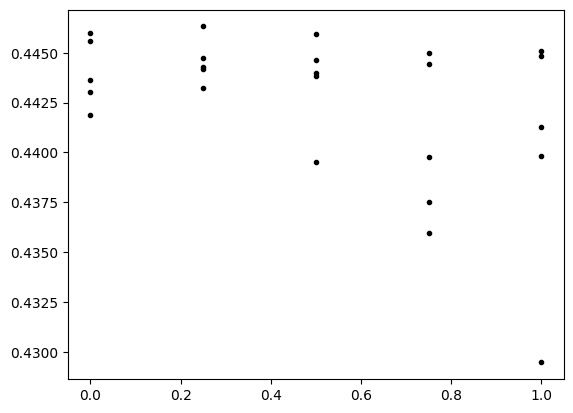

In [371]:
for key, value in evaluate.items():
    plt.plot(key[0], value[5], 'k.')
    
plt.show()

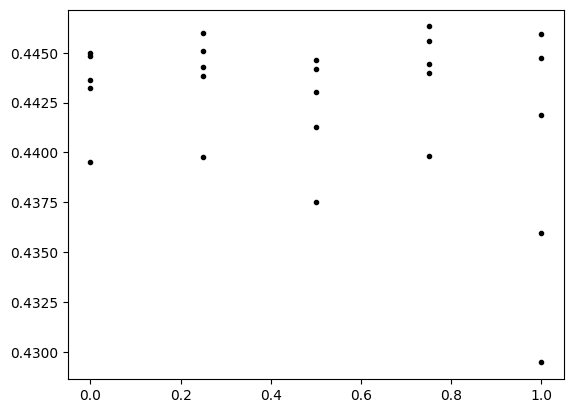

In [367]:
for key, value in evaluate.items():
    plt.plot(key[1], value[5], 'k.')

plt.show()

In [357]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [363]:
x = []
y = []
z = []
for key, value in evaluate.items():
    x.append(key[0])
    y.append(key[1])
    z.append(value[3])

In [364]:
print(x)
print(y)
print(z)

[0, 0, 0, 0, 0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1]
[0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1, 0, 0.25, 0.5, 0.75, 1]
[0.4548, 0.4548, 0.4536, 0.4572, 0.4528, 0.4548, 0.4572, 0.456, 0.458, 0.4548, 0.4532, 0.4552, 0.4516, 0.4544, 0.456, 0.4544, 0.4532, 0.4536, 0.4528, 0.45, 0.456, 0.458, 0.4528, 0.4488, 0.4496]
